# PyTorch ANN on MINST Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

In [2]:
transform = transforms.ToTensor()     

In [36]:
train_data = datasets.MNIST(root='../Data/1',train=True,download=True,transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data/1',train=False,download=True,transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data/1
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data/1
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [8]:
# train_data[5]

In [9]:
image,label = train_data[0]

In [10]:
image.shape

torch.Size([1, 28, 28])

In [11]:
label

5

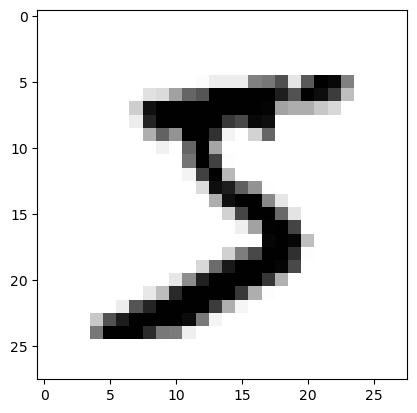

In [12]:
plt.imshow(image.reshape((28,28)), cmap='gist_gray_r'); # to reverse color just gray

In [13]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [14]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [15]:
for images,labels in  train_loader:
    break    

In [16]:
images.shape

torch.Size([100, 1, 28, 28])

In [17]:
labels.shape

torch.Size([100])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


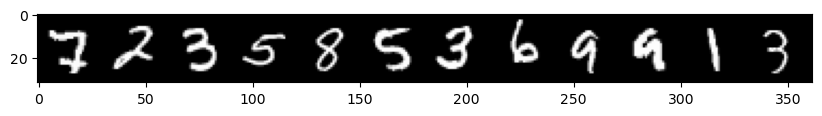

In [18]:
print('Labels: ', labels[:12].numpy())

im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


## Building the ANN

In [19]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784,out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)


    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1) # For multi class classification 


In [20]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
gpumodel = model.cuda()

In [34]:
next(gpumodel.parameters()).is_cuda

True

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)                                

In [22]:
images.shape # need to flatten

torch.Size([100, 1, 28, 28])

In [23]:
images.view(100, -1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Model Training

In [24]:
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epoch {i}  batch{b}  loss: {loss.item()}  accuracy: {acc} ')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted==y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        

total_time = time.time() - start_time
print(f'Duration: {total_time/60} minutes.')

Epoch 0  batch200  loss: 0.23541301488876343  accuracy: 83.25 
Epoch 0  batch400  loss: 0.35372811555862427  accuracy: 87.5275 
Epoch 0  batch600  loss: 0.13645225763320923  accuracy: 89.57333333333334 
Epoch 1  batch200  loss: 0.2445889711380005  accuracy: 94.84 
Epoch 1  batch400  loss: 0.14444680511951447  accuracy: 95.055 
Epoch 1  batch600  loss: 0.07348378002643585  accuracy: 95.355 
Epoch 2  batch200  loss: 0.08600125461816788  accuracy: 96.55 
Epoch 2  batch400  loss: 0.06034965440630913  accuracy: 96.6425 
Epoch 2  batch600  loss: 0.06324753910303116  accuracy: 96.71333333333334 
Epoch 3  batch200  loss: 0.11463852971792221  accuracy: 97.635 
Epoch 3  batch400  loss: 0.06223197281360626  accuracy: 97.475 
Epoch 3  batch600  loss: 0.030628442764282227  accuracy: 97.495 
Epoch 4  batch200  loss: 0.11356642842292786  accuracy: 98.195 
Epoch 4  batch400  loss: 0.04613405838608742  accuracy: 98.045 
Epoch 4  batch600  loss: 0.05497684329748154  accuracy: 98.045 
Epoch 5  batch200  

### Model Evaluation

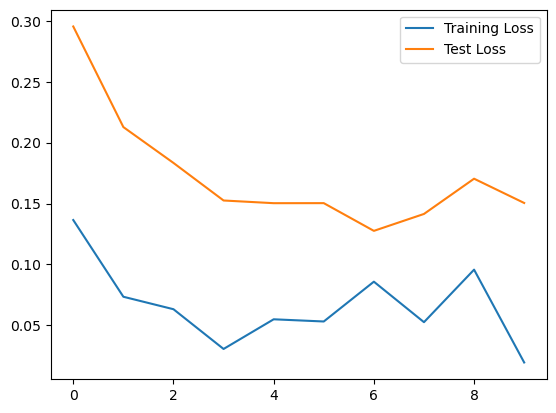

In [25]:
with torch.no_grad():
    plt.plot(train_losses,label="Training Loss")
    plt.plot(test_losses,label="Test Loss")
    plt.legend()

In [26]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

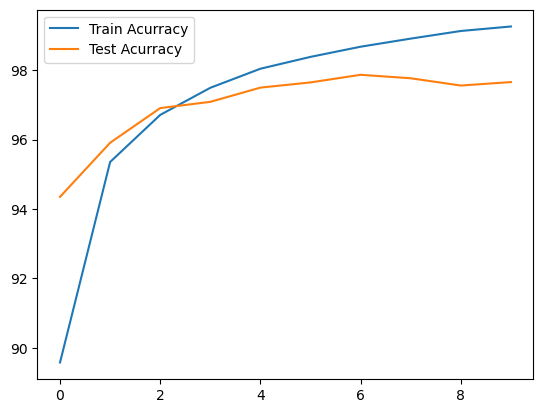

In [27]:
plt.plot(train_acc, label="Train Acurracy")
plt.plot(test_acc, label="Test Acurracy")
plt.legend()

#### How to run new unseen data through the model

In [28]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [29]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted==y_test).sum()

In [30]:
100*correct.item()/len(test_data)

97.66

In [31]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 974,    0,    5,    0,    2,    2,    5,    3,    4,    5],
       [   0, 1124,    3,    0,    0,    0,    3,    9,    0,    2],
       [   0,    3, 1002,    3,    1,    0,    1,   11,    2,    0],
       [   3,    2,    6,  991,    0,   14,    1,    1,    3,    3],
       [   0,    0,    2,    0,  966,    3,    2,    3,    3,    9],
       [   0,    0,    0,    3,    0,  854,    2,    1,    2,    2],
       [   1,    1,    1,    0,    5,    4,  943,    1,    1,    0],
       [   0,    0,    3,    2,    0,    2,    0,  977,    2,    0],
       [   2,    5,   10,    6,    1,   12,    1,    3,  952,    5],
       [   0,    0,    0,    5,    7,    1,    0,   19,    5,  983]])